## Executive Summary

# Introduction

The purpose of this study is to build a linear regression model that will predict the number of covid-19 cases for any Toronto neighborhood based on its demographic data. Predicting covid-19 cases is useful in that an understanding of which socioeconomic factors that influence the growth of disease in a community will help with our understanding of the virus. This knowledge will enable resources to be better targeted in the future to help prevent transmission during this, or any future pandemic.

### Load Libraries

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
%matplotlib inline
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

## Data

A population Census is held across Canada every 5 years. It collects data about age and sex, families and households, language, immigration and internal migration, racial diversity, Aboriginal peoples, housing, education, income, and labor. 
The City of Toronto Neighborhood Profiles use this Census data to provide a portrait of the demographic, social and economic characteristics of the people and households in each City of Toronto neighborhood.



The data is made available through Toronto's Open Data portal (https://open.toronto.ca/).

Two datasets from this site were used for this study. One that shows the number of covid cases by Toronto neighborhood (https://open.toronto.ca/dataset/covid-19-cases-in-toronto/) and the other contains demographic features of each of these neighborhoods (https://open.toronto.ca/dataset/neighbourhood-profiles/). There are over 2,300 features show for each neighborhood including:

### Load Files

In [2]:
covid_to = pd.read_csv('data/CityofToronto_COVID-19_NeighbourhoodData.csv')

In [3]:
neigh = pd.read_csv("data/neighbourhood-profiles-2016-csv_ADJ.csv")

### Data Cleaning

The demographic data is a huge dataset containing over 2300 rows, each one representing a different demographic feature. In order to create one usable dataset the following tasks were performed:

1. The dataset was transposed so that the columns, which are the Toronto neighborhoods become row and each feature becomes a column.
2. Every column is given a unique identifying name.
3. A dataframe was created to capture the column descriptions which are quite lengthy.
4. Null rows were dropped - these were summary rows which did not relate to each neighborhood.
5. All the numeric columns were converted to floats - there were no categorical columns.
6. The two dataframes (demographic data and covid case data) were merged on the neighborhood id column to create one dataframe.

In [4]:
# The Neighbourhood file has Neighbourhoods as columns so we must 
# transpose it.
neighTO = neigh.transpose()

There are over 2300 columns. Let's keep track of the names meanings of these columns so we can 
later use this information to interpret the results. In the meantime we will refer to the columns by
their numeric names.

In [5]:
# Let's the column names to strings
neighTO.columns = ["Col_" + str(x) for x in neighTO.columns]

In [6]:
colNames = neighTO.iloc[0:5,:].transpose()

In [7]:
# Now we have a dataframe of all the column names
colNames.head(5).iloc[:,0:5]

,_id,Category,Topic,Special,Characteristic
Col_0,1,Neighbourhood Information,Neighbourhood Information,NaN,Neighbourhood Number
Col_1,1,Neighbourhood Information,Neighbourhood Information,NaN,Neighbourhood Number
Col_2,3,Population,Population and dwellings,X,"Population, 2016"
Col_3,4,Population,Population and dwellings,NaN,"Population, 2011"
Col_4,6,Population,Population and dwellings,NaN,Total private dwellings


In [8]:
# Let's remove all the descriptive rows
neighTO = neighTO.iloc[5:,:]

In [9]:
# We can remove the city of Toronto
neighTO = neighTO[neighTO.index != 'City of Toronto']

In [10]:
# Let's ensure the neighborhoodID in both files is an int so we can
# join the files
neighTO['Col_0'] = neighTO['Col_0'].astype(int)

In [11]:
# We drop the null row and convert ID to int
covid_to.dropna(inplace=True)
covid_to['Neighbourhood ID'] = covid_to['Neighbourhood ID'].astype(int)

In [12]:
# Let's convert the demographic data to floats - select only string columns
for x in neighTO.select_dtypes(include='object').columns:
    if x != 'Col_0':
        # Remove % symbol if present
        neighTO[x] = neighTO[x].replace({'%':''}, regex = True)
        neighTO[x] = neighTO[x].astype(float)

In [13]:
# We see they are all floats except for the int column
neighTO.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, Agincourt North to Yorkdale-Glen Park
Columns: 2306 entries, Col_0 to Col_2305
dtypes: float64(2305), int64(1)
memory usage: 2.5+ MB


In [14]:
# Now we can see that all our columns are numeric
neighTO.describe().iloc[:,1:5]

,Col_1,Col_2,Col_3,Col_4
count,140.000000,140.000000,140.000000,140.000000
mean,0.434000,19511.221429,96.683000,42.818071
std,0.319835,10033.589222,6.728256,8.067717
min,0.000000,6577.000000,65.790000,29.450000
25%,0.185000,12019.500000,95.925000,37.540000
50%,0.360000,16749.500000,98.550000,40.930000
75%,0.630000,23854.500000,100.347500,45.862500
max,1.700000,65913.000000,108.220000,71.620000


We need to join the datasets so we have one dataset with all the features and target.

In [15]:
# Rename the column so they match in both files
neighTO.rename(columns={'Col_0': "Neighbourhood ID"}, inplace=True)

In [16]:
# Join the files on Neighbourhood ID
NeighCases = pd.merge(neighTO, covid_to, how='left', on=['Neighbourhood ID'])

In [17]:
# Let's write this to excel to back it up.
NeighCases.to_csv("data/NeigCases.csv")

## Data Exploration

There's a huge difference in the rate of covid-19 cases in each Toronto neighborhood. 

The top 5 neighborhoods **dramatically higher case rates** than the bottom five neighborhoods (Figure 1).

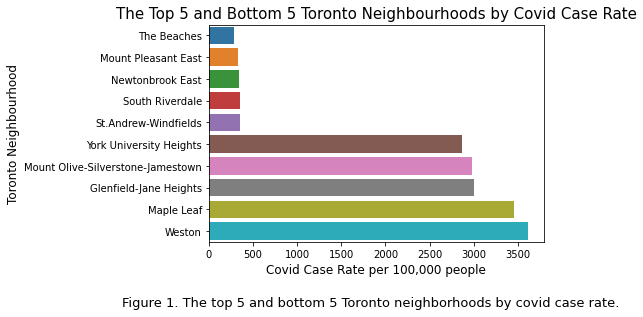

In [18]:
sns.reset_orig()
df = NeighCases[['Neighbourhood Name', "Rate per 100,000 people"]].sort_values("Rate per 100,000 people")
df.columns = ['Neighbourhood', 'Rate per 100,000 people']

ax = sns.barplot(data=df.head(5).append(df.tail(5)), y='Neighbourhood',x='Rate per 100,000 people',orient='h')
txt="Figure 1. The top 5 and bottom 5 Toronto neighborhoods by covid case rate."
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=13)

plt.title('The Top 5 and Bottom 5 Toronto Neighbourhoods by Covid Case Rate',fontsize= 15)
plt.xlabel("Covid Case Rate per 100,000 people", fontsize=12)
plt.ylabel("Toronto Neighbourhood", fontsize=12);

The rate in the neighborhood of Weston has a covid case rate of almost 13 times that of the Beaches neighborhood.

In [19]:
df.head(1).append(df.tail(1))

,Neighbourhood,"Rate per 100,000 people"
116,The Beaches,282.839523
126,Weston,3612.716763


Various media reports have shown that certain demographic factors can influence covid rates. Reports have shown that the virus has disproportionately affected communities based on the following factors:


* Racial Profile<br>
* Density<br>
* Employment<br>
* Income<br>

Let's examine some columns that correspond to these factors and see how they relate to covid rate.

In [20]:
colNames.Category.unique()

array(['Neighbourhood Information', 'Population',
       'Families, households and marital status', 'Language', 'Income',
       'Immigration and citizenship', 'Visible minority', 'Ethnic origin',
       'Aboriginal peoples', 'Education', 'Housing', 'Language of work',
       'Labour', 'Journey to work', 'Mobility'], dtype=object)

Figure 2 shows the how covid rates vary depending on the proportion of different racial groups in each Toronto neighborhood. 

There seems to be a moderate positive relationship between covid rates and the percent of Blacks in each neighborhood and also Latin Americans.

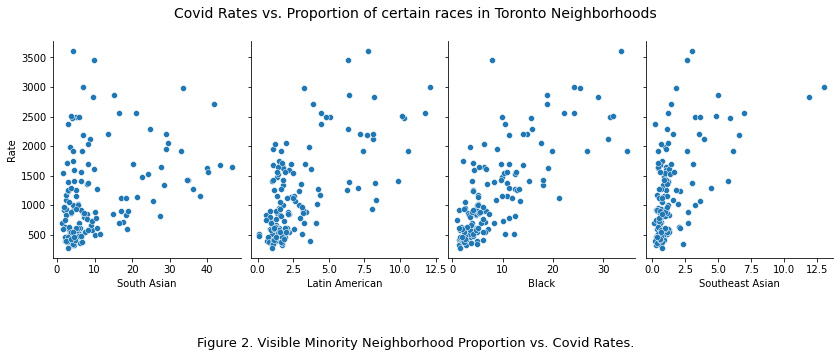

In [21]:
# Let's look at the top 5 visible minority categories
df = NeighCases[colNames[colNames['Category'] == 'Visible minority'].index]
df = df.rename(columns={"Col_1266": "Visible Minority", "Col_1267": "South Asian",
                  "Col_1077": "Latin American", "Col_1269": "Black", "Col_1272": "Southeast Asian"})
df['Rate'] = NeighCases['Rate per 100,000 people']
df = df[["South Asian", "Latin American", "Black", "Southeast Asian","Rate"]]
# Create the pairplot
ax = sns.pairplot(data=df, 
            x_vars=["South Asian", "Latin American", "Black", "Southeast Asian"],
            y_vars=['Rate'], diag_kind=None);
# Add titles
ax.fig.suptitle("Covid Rates vs. Proportion of certain races in Toronto Neighborhoods", y=1.08, fontsize=14) # y= some height>1
txt="Figure 2. Visible Minority Neighborhood Proportion vs. Covid Rates."
# plt.title("The proportion of selected visible minority groups in Toronto neighborhoods vs. Covid Rates", loc="left");
# Set the size
ax.fig.set_size_inches(12,4)
# Add the figure text below
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=13);

Now lets check some other potential predictors, including income, density and employment.

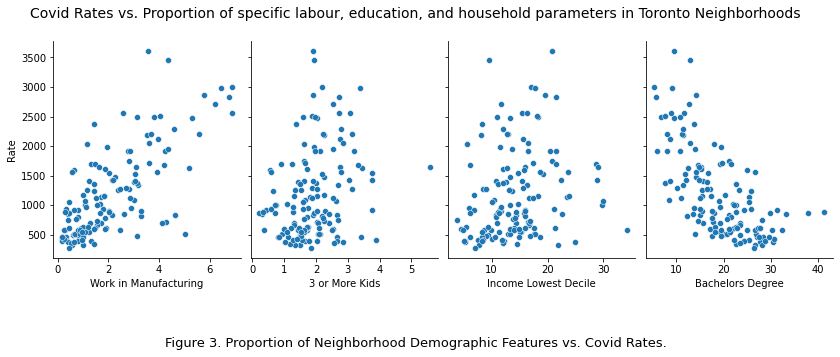

In [22]:
# Let's look at the top 5 visible minority categories
df = NeighCases[["Col_1855", "Col_100", "Col_1047", "Col_1635"]]
df = df.rename(columns={"Col_1855": "Work in Manufacturing", "Col_100": "3 or More Kids",\
                        "Col_1047": "Income Lowest Decile", "Col_1635": "Bachelors Degree"})

df['Rate'] = NeighCases['Rate per 100,000 people']
# df = df[["South Asian", "Latin American", "Black", "Southeast Asian","Rate"]]
# Create the pairplot
ax = sns.pairplot(data=df, 
            x_vars=["Work in Manufacturing", "3 or More Kids",\
                    "Income Lowest Decile", "Bachelors Degree"],
            y_vars=['Rate'], diag_kind=None);
# Add titles
ax.fig.suptitle("Covid Rates vs. Proportion of specific labour, education, and household parameters in Toronto Neighborhoods", y=1.08, fontsize=14) # y= some height>1
txt="Figure 3. Proportion of Neighborhood Demographic Features vs. Covid Rates."
# plt.title("The proportion of selected visible minority groups in Toronto neighborhoods vs. Covid Rates", loc="left");
# Set the size
ax.fig.set_size_inches(12,4)
# Add the figure text below
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=13);

There seems to be a positive trend between the proportion of the population that work in manufacturing jobs in a neighborhood vs. covid rates, and a negative trend between the proportion who have Bachelor's Degrees (Figure 3).

## Feature Selection

There are so many features (over 2,300) so in order to narrow it down we will examine the correlation of every feature to the target (Covid rate per 100,000 people). We will select the top 100 of based on this correlation and use this as our new pared down dataset.

In [23]:
# Let's look at all the features and how they compare to 
# the target - this will show the top 100 features
cor = NeighCases.corr()
threshold = 0.6
a=abs(cor['Rate per 100,000 people'])
result=pd.DataFrame(a[a>0.6])
feat_cor = result.sort_values('Rate per 100,000 people', ascending=False).head(100)

In [24]:
# Let's remove the Case Count column and examine these variables
feat_cor.drop('Case Count', inplace=True)
# feat_cor.drop('Rate per 100,000 people', inplace=True)

In [25]:
try:
    feat_cor.reset_index(level=0, inplace=True)
except:
    None

In [26]:
try:
    colNames.reset_index(level=0, inplace=True)
except:
    None

In [27]:
dfCol = colNames[['index','Category', 'Characteristic']]

In [28]:
feat_corName = pd.merge(feat_cor, dfCol, how='left', on=['index'])

The top 10 features in order of descending correlation to "Rate per 100,000" column. The top features are all seemingly related to Black, Caribbean and African origins except for a Labor related column which is Occupations in manufacturing and utilities.

In [29]:
# Here are the top 10 features in order of desending correlation to "Rate per 100,000"
feat_corName.sort_values(by='Rate per 100,000 people', ascending=False).head(10)

,index,"Rate per 100,000 people",Category,Characteristic
0,"Rate per 100,000 people",1.000000,NaN,NaN
1,Col_1269,0.744447,Visible minority,Black
2,Col_1105,0.741047,Immigration and citizenship,Jamaica
3,Col_1099,0.737303,Immigration and citizenship,Americas
4,Col_1377,0.731488,Ethnic origin,Jamaican
5,Col_329,0.727007,Language,Niger-Congo languages
6,Col_1855,0.726108,Labour,9 Occupations in manufacturing and utilities
7,Col_1135,0.724949,Immigration and citizenship,Nigeria
8,Col_1414,0.713611,Ethnic origin,Central and West African origins
9,Col_1329,0.712460,Ethnic origin,Caribbean origins


Let's look at the top correlation in each Category of predictors. The category with the top correlated predictor is "Visible Minority" (**0.75**) and "Housing" is the category with the lowest correlated predictor (**0.63**).

In [30]:
# Return top from each category
groupMax = feat_corName.groupby(["Category"])
groupMax.max('Rate per 100,000 people')

,"Rate per 100,000 people"
Category,
Education,0.677412
Ethnic origin,0.731488
"Families, households and marital status",0.690762
Housing,0.629968
Immigration and citizenship,0.741047
Income,0.684972
Journey to work,0.666669
Labour,0.726108
Language,0.727007


It seems logical that predictors within the same category would be correlated, so let's find the top correlated predictor within each category.

In [31]:
# *****
# Let's find the rows with the highest value for each category
idx = feat_corName.groupby(['Category'])['Rate per 100,000 people'].transform(max) == \
feat_corName['Rate per 100,000 people']
feat_corName[idx]

,index,"Rate per 100,000 people",Category,Characteristic
1,Col_1269,0.744447,Visible minority,Black
2,Col_1105,0.741047,Immigration and citizenship,Jamaica
4,Col_1377,0.731488,Ethnic origin,Jamaican
5,Col_329,0.727007,Language,Niger-Congo languages
6,Col_1855,0.726108,Labour,9 Occupations in manufacturing and utilities
14,Col_105,0.690762,"Families, households and marital status",3 or more children
16,Col_1049,0.684972,Income,In the third decile
19,Col_1635,0.677412,Education,Bachelor's degree
27,Col_1907,0.666669,Journey to work,Between 12 p.m. and 4:59 a.m.
74,Col_1594,0.629968,Housing,2 household maintainers


In [32]:
# Let's create a dataframe using only these values and let's make the
# columns more readable.
NeighCovid = NeighCases[feat_corName[idx]['index']]
NeighCovid['Rate'] = NeighCases['Rate per 100,000 people']

In [33]:
NeighCovid.columns = ['Black%', 'Jamaica%', 'Jamaican', 'CongoLang', 'ManufactJob', 'MoreThan2Kids',\
                      'ThirdDecIncome', 'BachelorDegree', 'WorkNights', 'BothMaintHouse', 'Rate']

### Remove Correlated Predictors

If certain features are highly correlated with other ones then there are redundant features and they can be removed to make the model more simple. The following heatmap shows that there are several highly correlated features, for example _Black_ with *Jamaica%*, *Jamaican*, *CongoLang* and *MoreThan2Kids*.

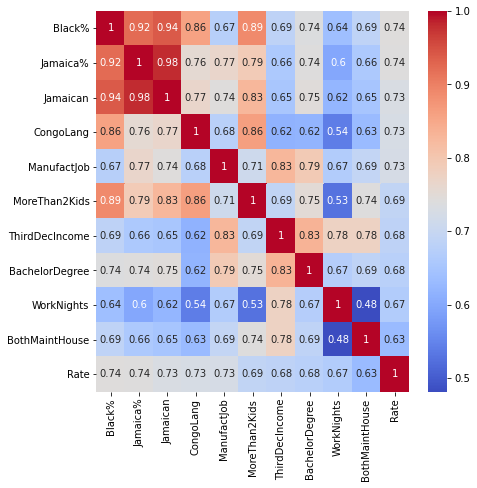

In [34]:
# Correlation of variables
plt.figure(figsize=(7,7))
sns.heatmap(abs(NeighCovid.corr()), annot=True, cmap="coolwarm");

It makes sense than language, ethnic origin, language and visible minority categories of data
are highly correlated. Let's remove the *Jamaica%*, *Jamaican*, and *CongoLang* predictors.

In [35]:
# Remove columns from dataset
NeighCovid.drop(['Jamaica%', 'Jamaican', 'CongoLang'], axis=1, inplace=True)

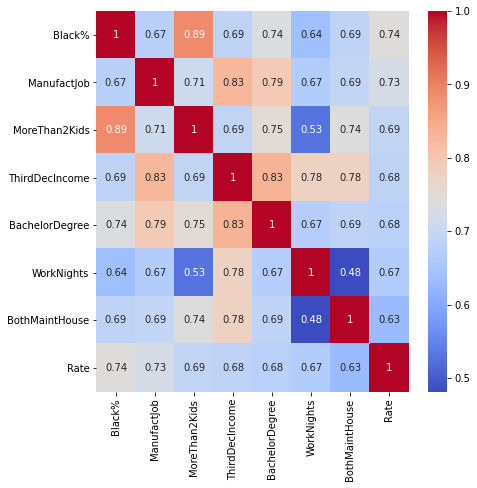

In [36]:
# Check the heatmap again
plt.figure(figsize=(7,7))
sns.heatmap(abs(NeighCovid.corr()), annot=True, cmap="coolwarm");

In the interest of simplicity we can reduce features further. Black and Morethan2Kids is highly correlated, as well as ManufactJob and ThirdDecIncome so we will reduce the features that are least correlated with Rate.

In [37]:
NeighCovid.drop(['MoreThan2Kids', 'ThirdDecIncome'], axis=1, inplace=True)

Let's look at the heatmap of feature correlations. We can now see that we have all the correlations are under **0.80**. Let's use these remaining features to build a model.

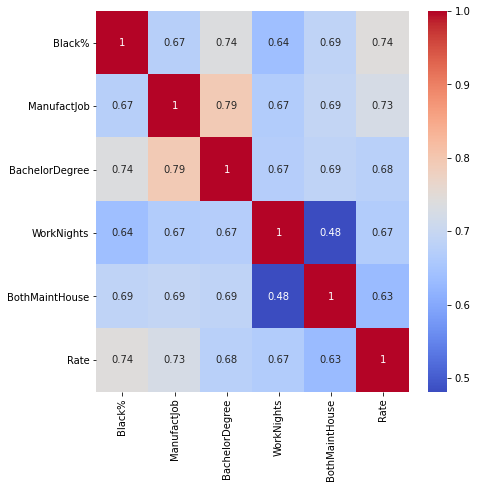

In [38]:
plt.figure(figsize=(7,7))
sns.heatmap(abs(NeighCovid.corr()), annot=True, cmap="coolwarm");

## Results

### Linear Regression

#### Simple Linear Regression

Let's start with a simple linear regression model. We will use only one feature to predict the one target (Covid Rate). We will use the column which is most highly correlated to Covid Rate which is the percent of Black people in each neighborhood.

In [154]:
# Install Functions
%run ./CovidFunctions.ipynb

In [148]:
# Create the X and y datasets
OLR_df = NeighCovid[['Black%','Rate']]

In [149]:
ReturnR2value(OLR_df)

,Intercept,Coefficient(s),Root MSE,R^2 Value
0,1217.107304,[535.789465],313.208682,49.09


In [150]:
MLR_df = NeighCovid

In [151]:
mdf = ReturnR2value(MLR_df)

In [155]:
mdf

,Intercept,Coefficient(s),Root MSE,R^2 Value
0,1212.274183,[243.43479435 268.55131837 19.12543137 175.77...,330.036755,43.47


In [152]:
l = mdf['Coefficient(s)'].str.split()

In [153]:
l[0][3]

'175.77054901'

In [134]:
[x for x in l]

[['[243.43479435',
  '268.55131837',
  '19.12543137',
  '175.77054901',
  '-47.11452887]']]

['[243.43479435 268.55131837  19.12543137 175.77054901 -47.11452887]']

In [125]:
[s]

0    [243.43479435 268.55131837  19.12543137 175.77...
Name: Coefficient(s), dtype: object

In [128]:
list(s)

['[243.43479435 268.55131837  19.12543137 175.77054901 -47.11452887]']

In [127]:
s = s.split()

AttributeError: 'Series' object has no attribute 'split'